In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore, f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import glob

In [5]:
df = pd.read_csv('/Users/owlxshri/Desktop/coral reef/mlpr-project/finaldata/enso_conv.csv')

# 1. Data Inspection & Cleaning
print("Initial Data Inspection:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

Initial Data Inspection:
Shape: (1672, 4)

First 5 rows:
   Day     Month  Year     Value
0   18   October  1992  0.315273
1   26   October  1992  0.311238
2    2  November  1992  0.375543
3    9  November  1992  0.527112
4   15  November  1992  0.634374

Missing Values:
Day      0
Month    0
Year     0
Value    0
dtype: int64


In [6]:
# Convert to datetime
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1), format='%Y-%B-%d')
print(f"\nDate Range: {df['Date'].min()} to {df['Date'].max()}")


Date Range: 1992-10-18 00:00:00 to 2025-01-12 00:00:00


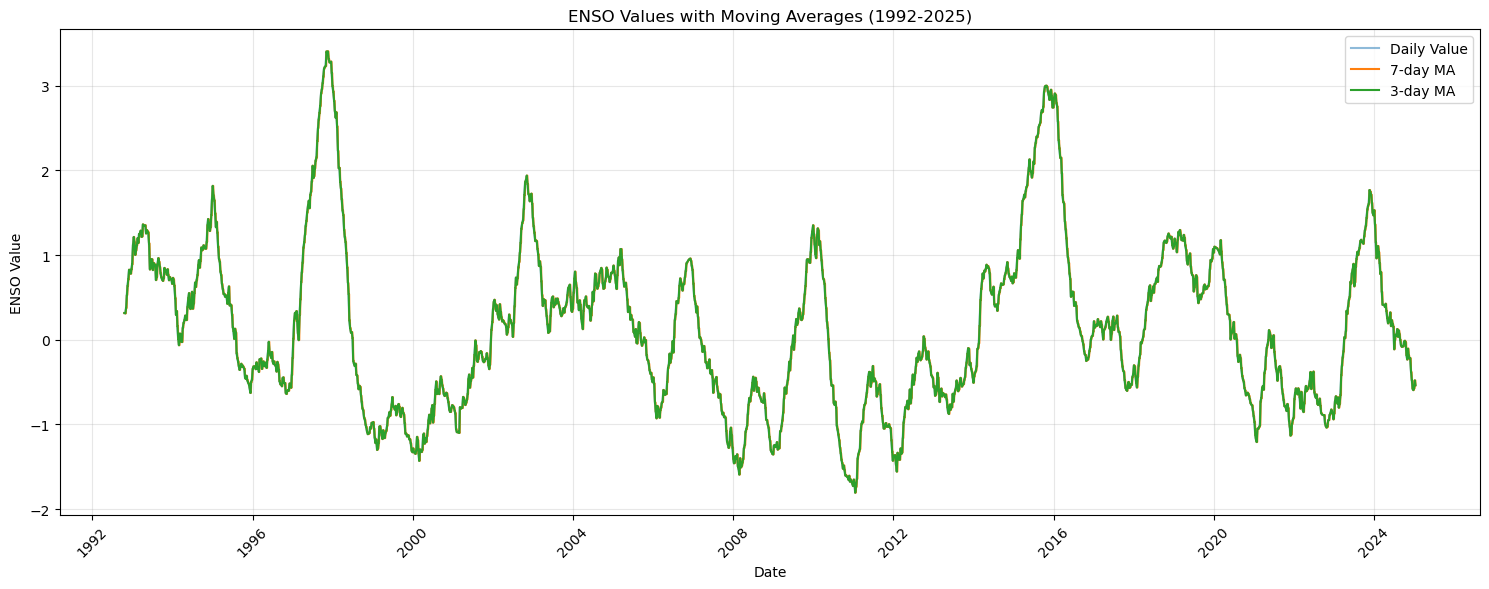

In [21]:
# 3. Temporal Analysis with Moving Averages
plt.figure(figsize=(15, 6))
df['7_day_MA'] = df['Value'].rolling(window=7, min_periods=1).mean()
df['3_day_MA'] = df['Value'].rolling(window=3, min_periods=1).mean()

sns.lineplot(data=df, x=df.index, y='Value', label='Daily Value', alpha=0.5)
sns.lineplot(data=df, x=df.index, y='7_day_MA', label='7-day MA')
sns.lineplot(data=df, x=df.index, y='3_day_MA', label='3-day MA')
plt.title('ENSO Values with Moving Averages (1992-2025)')
plt.xlabel('Date')
plt.ylabel('ENSO Value')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


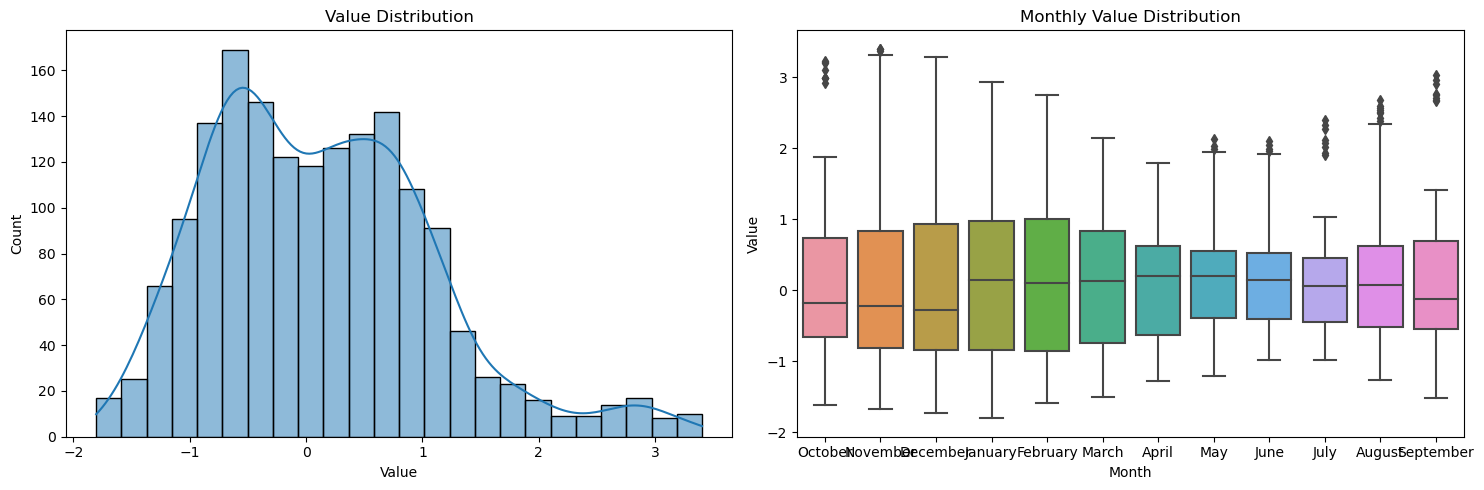

In [8]:
# 3. Distribution Analysis
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(df['Value'], kde=True, ax=ax[0])
ax[0].set_title('Value Distribution')
sns.boxplot(x=df['Month'], y=df['Value'], ax=ax[1])
ax[1].set_title('Monthly Value Distribution')
plt.tight_layout()
plt.show()

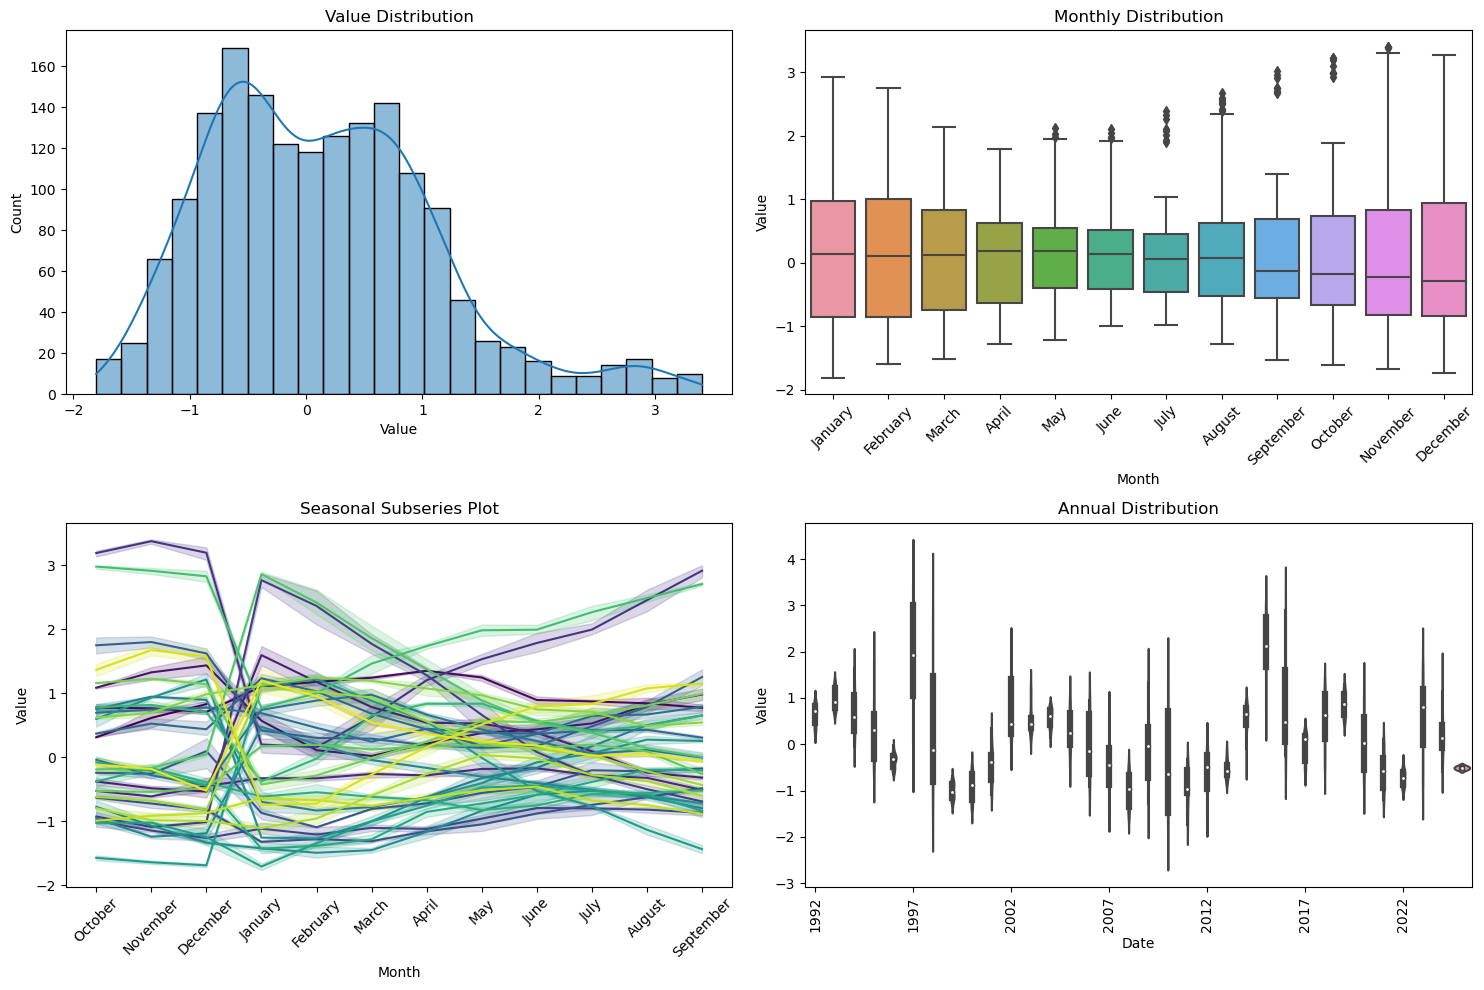

In [22]:
# 4. Distribution Analysis
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with KDE
sns.histplot(df['Value'], kde=True, ax=ax[0,0])
ax[0,0].set_title('Value Distribution')

# Boxplot by Month
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
sns.boxplot(x=df['Month'], y=df['Value'], order=month_order, ax=ax[0,1])
ax[0,1].set_title('Monthly Distribution')
ax[0,1].tick_params(axis='x', rotation=45)

# Seasonal Subseries Plot
seasonal_df = df.copy()
seasonal_df['Year'] = seasonal_df.index.year
sns.lineplot(x='Month', y='Value', hue='Year', data=seasonal_df, 
            estimator='mean', ax=ax[1,0], palette='viridis', legend=False)
ax[1,0].set_title('Seasonal Subseries Plot')
ax[1,0].tick_params(axis='x', rotation=45)

# Annual Distribution
sns.violinplot(x=df.index.year, y=df['Value'], ax=ax[1,1])
ax[1,1].set_title('Annual Distribution')
ax[1,1].tick_params(axis='x', rotation=90)
ax[1,1].set_xticks(ax[1,1].get_xticks()[::5])  # Show every 5th year

plt.tight_layout()
plt.show()

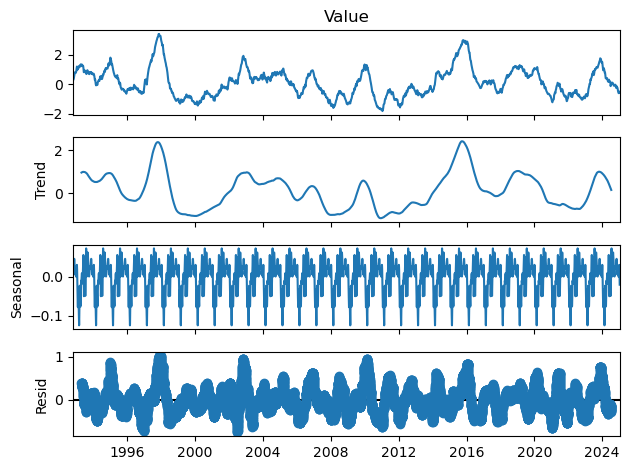

In [23]:
# 5. Advanced Time Series Analysis
# Decomposition with 365-day period
result = seasonal_decompose(df['Value'].interpolate(), model='additive', period=365)
result.plot()
plt.tight_layout()
plt.show()

In [24]:
# 6. Statistical Analysis
print("\nKey Statistics:")
print(f"Date Range: {df.index.min().date()} to {df.index.max().date()}")
print(f"Value Range: {df['Value'].min():.2f} to {df['Value'].max():.2f}")
print("\nCorrelation with Moving Averages:")
print(df[['Value', '3_day_MA', '7_day_MA']].corr())



Key Statistics:
Date Range: 1992-10-18 to 2025-01-12
Value Range: -1.80 to 3.40

Correlation with Moving Averages:
             Value  3_day_MA  7_day_MA
Value     1.000000  1.000000  0.999769
3_day_MA  1.000000  1.000000  0.999923
7_day_MA  0.999769  0.999923  1.000000


In [25]:
# 7. Outlier Detection
Q1 = df['Value'].quantile(0.25)
Q3 = df['Value'].quantile(0.75)
IQR = Q3 - Q1
print(f"\nIQR Range: {Q1 - 1.5*IQR:.2f} to {Q3 + 1.5*IQR:.2f}")
print("Potential Outliers:", df[(df['Value'] < (Q1 - 1.5*IQR)) | 
                               (df['Value'] > (Q3 + 1.5*IQR))].shape[0])



IQR Range: -2.62 to 2.75
Potential Outliers: 36


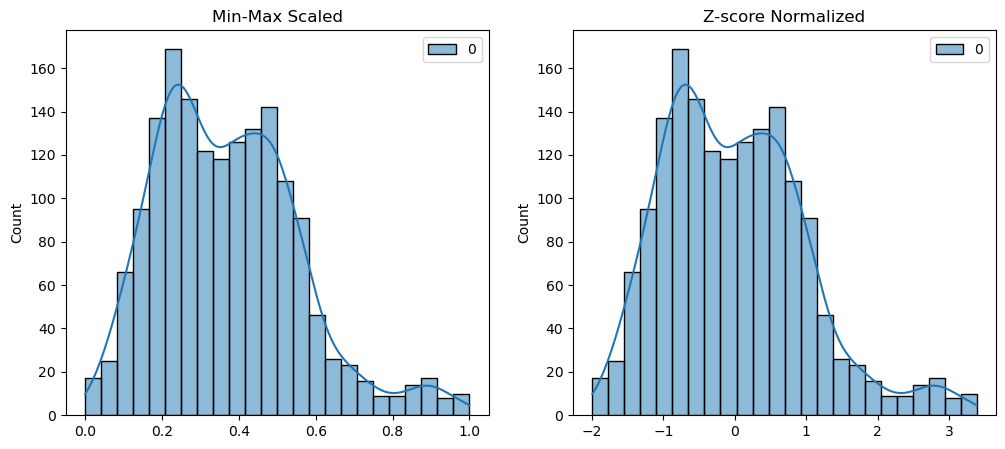

In [26]:
# 8. Normalization Comparison
scaler = MinMaxScaler()
standard_scaler = StandardScaler()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(scaler.fit_transform(df[['Value']]), kde=True)
plt.title('Min-Max Scaled')

plt.subplot(1,2,2)
sns.histplot(standard_scaler.fit_transform(df[['Value']]), kde=True)
plt.title('Z-score Normalized')
plt.show()